In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go

# The creation of an extremely accurate classifier

In this notebook, we will be trying to create a classifier for predicting individual finger movements from EEG data. Data were preprocessed as follows:

1. The data were **scaled** by performing z-scale transformation for each channel separately.
2. **Power line** noise was removed.
3. Frequencies **lower than 4 Hz** and **higher than 290 Hz** were removed.
4. **Bad quality channels** were detected.
    A channel is considered bad quality if it has low average correlation of the band power with the other channels. The minimum average correlation is determined for each run separately. The correlation is decreased by 0.001 (starting from 1) until the number of channels with lower correlation is less than 25.
5. Bad quality channels **were not removed**.
    The detected bad quality channels were kept because they should not be informative and thus should not be of much use to the classifier. Channel selection will be done for each subsample separately and these channels should be dropped during the process.
6. Data were subdivided into **epochs** and the **features** for the classifier were extracted.
    The data were cut into epochs of 0.5 seconds. For each of these epochs, the absolute power was calculated in the frequency bands from 5 Hz to 100 Hz with a step of 5 Hz.
7. Features of different runs from the same person were joined together.

The classifier described here performs supervised learning and predicts categorical value for each epoch (thumb, index, middle, ring, pinky, no finger).

In [3]:
feature_matrix = pd.read_csv('output/problem-at-hand/S2/all/feature_matrix.csv', index_col = 0)
key = pd.read_csv('output/problem-at-hand/S2/all/key.csv')

In [4]:
def extract_feature_channel(row):
    return re.sub('X([0-9]+)_[0-9]+', '\\1', row['FeatureID'])


def extract_feature_frequency(row):
    return re.sub('X[0-9]+_([0-9]+)', '\\1', row['FeatureID'])


feature_info = pd.DataFrame(feature_matrix.index)
feature_info['Channel'] = feature_info.apply(extract_feature_channel, axis = 1)
feature_info['Frequency'] = feature_info.apply(extract_feature_frequency, axis = 1)
feature_info['Frequency'] = feature_info['Frequency'].astype('int', copy = False)

In [29]:
print(f'The feature matrix has {feature_matrix.shape[0]} features and {feature_matrix.shape[1]} epochs.')
print('Reminder: a feature in this case is a specific power band frequency from a specific channel,')
print('          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.')

The feature matrix has 4864 features and 4150 epochs.
Reminder: a feature in this case is a specific power band frequency from a specific channel,
          e.g. X0_5: absolute power of 5-10 Hz band in channel X0.


In [6]:
key

,EventID,Run,Event
0,Event0_run1,run1,0.0
1,Event1_run1,run1,0.0
2,Event2_run1,run1,0.0
3,Event3_run1,run1,0.0
4,Event4_run1,run1,0.0
...,...,...,...
4145,Event410_run10,run10,6.0
4146,Event411_run10,run10,6.0
4147,Event412_run10,run10,6.0
4148,Event413_run10,run10,6.0


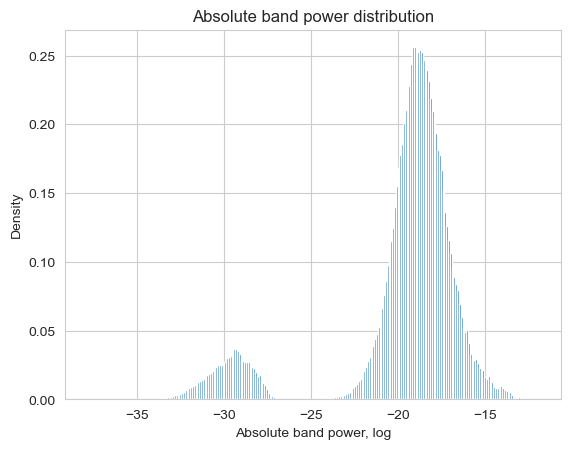

In [7]:
plt.hist(np.log(feature_matrix.values.flatten()), bins = 250, density = True)
plt.xlabel('Absolute band power, log')
plt.ylabel('Density')
plt.title('Absolute band power distribution')
plt.show()

After natural log transformation, the complete dataset displays a bimodal distribution. However, the data in each individual channel have normal distributions. This can be shown only visually (see examples below) as the statistical tests are very sensitive on large datasets.

From this we can make two conclusions. Firstly, the features can be scaled using the z-score transformation because the data is normally distributed after natural log transformation. Secondly, some features have extremely low absolute band power altogether and need to be further explored whether they are useful for the predictor.

In [8]:
def plot_distribution_with_normal(matrix, feature):
    feature_name = matrix.index[feature]
    data = np.log(matrix.values[feature, :])

    mean = np.mean(data)
    std_dev = np.std(data)

    # Thanks to ChatGPT, we generate a normal distribution and calculate the probability density function
    norm_x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
    pdf_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(norm_x - mean) ** 2 / (2 * std_dev ** 2))

    plt.hist(data, bins = 15, density = True, label = f'Feature {feature_name}')
    plt.plot(norm_x, pdf_values, linewidth = 2, label = 'Normal Distribution')
    plt.xlabel('Absolute band power, log')
    plt.ylabel('Density')
    plt.title(f'Absolute band power distribution of a single feature with a mean of {round(mean)}')
    plt.legend()
    plt.show()

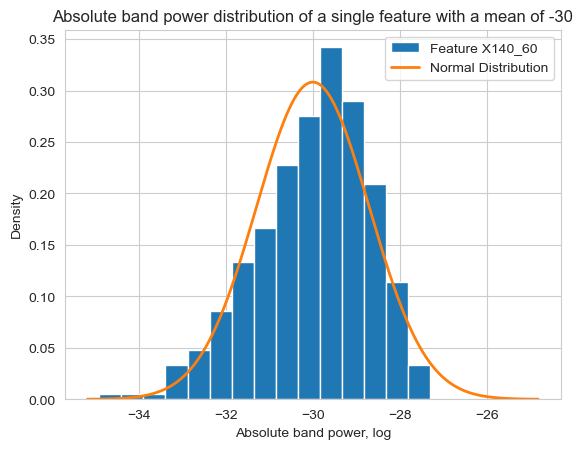

In [9]:
plot_distribution_with_normal(feature_matrix, feature = 866)

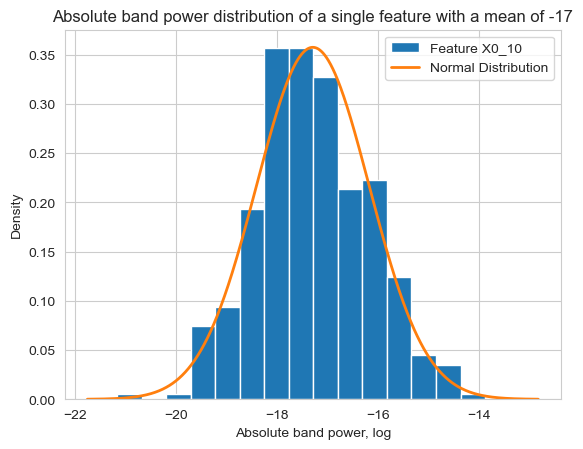

In [10]:
plot_distribution_with_normal(feature_matrix, feature = 0)

## Filter out non-informative features

Non-informative features will be filtered out before training the models. Non-informative features are those that have an extremely low coefficient of variation. For the data that is log-normally distributed an estimate of coefficient of variation is defined as:

$$\hat{cv} = \sqrt{e^{s^{2}_{ln}} - 1}$$

where $s_{ln}$ is the standard deviation of the data after the natural log transformation.

In [11]:
# Log-transform
x = np.log(feature_matrix.values)

# Center
x = x.T - np.mean(x, axis = 1)
x = x.T

cv = np.sqrt(np.power(np.e, np.power(np.std(x, axis = 1), 2)) - 1)
assert len(cv) != len(key)

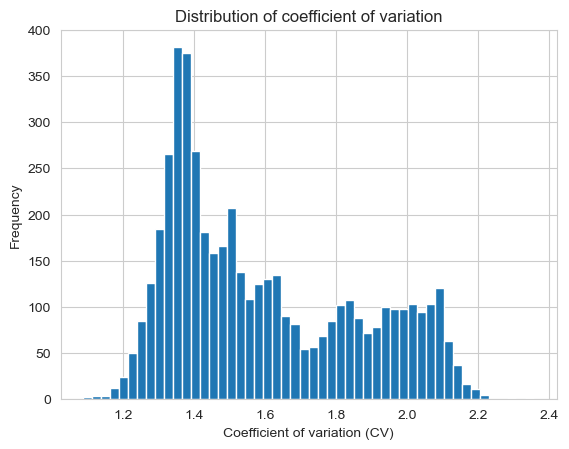

In [12]:
plt.hist(cv, bins = 50)
plt.xlabel('Coefficient of variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of coefficient of variation')
plt.show()

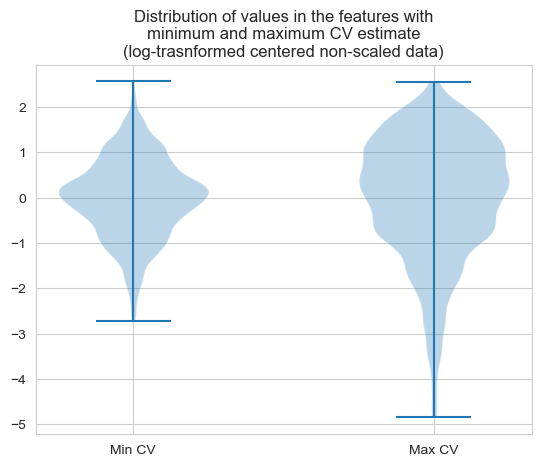

In [13]:
idx_max = np.argmax(cv)
idx_min = np.argmin(cv)

plt.violinplot(x[[idx_min, idx_max], :].T)
plt.title(
    'Distribution of values in the features with\nminimum and maximum CV estimate\n(log-trasnformed centered non-scaled data)')
plt.xticks([1, 2], ['Min CV', 'Max CV'])
plt.show()

The CV seems quite high for all the features, and the data is well distributed for both the minimal and the maximal CV values. Seems like the features with low mean value carry some information and may be informative to the classifier.

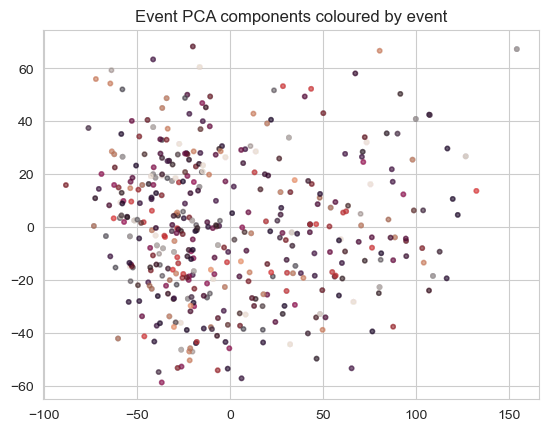

In [14]:
pca = PCA(n_components = 2).fit_transform(x.T)
assert pca.shape[0] == len(key)

plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Event']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by event')
plt.show()

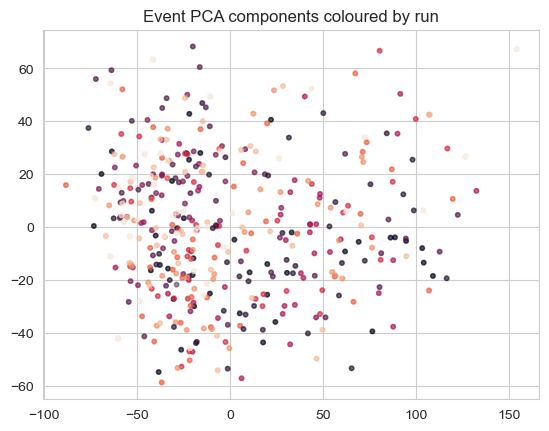

In [15]:
plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(key['Run']),
            s = 10,
            alpha = 0.1)
plt.title('Event PCA components coloured by run')
plt.show()

In the PCA plot, there seems to be no separation by finger. Which is quite sad. However, there's no separation by run as well which is good.

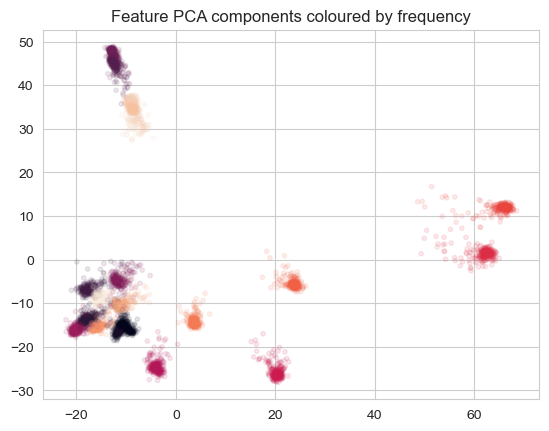

In [16]:
pca = PCA(n_components = 2).fit_transform(x)
assert pca.shape[0] == len(feature_info)

plt.scatter(pca[:, 0], pca[:, 1],
            c = LabelEncoder().fit_transform(feature_info['Frequency']),
            s = 10,
            alpha = 0.1)
plt.title('Feature PCA components coloured by frequency')
plt.show()

Quite interesting. There seems to be a clear separation by feature frequency. I expected that there would be a separation by channel (as some channels were quite low quality) and we could drop some features that are clearly bad in the PCA but that is not the case. Seems like feature selection will have to be done for each fold individually.

## Classifier

In [283]:
def create_splits(x, y, n_splits = 5):
    validator = StratifiedKFold(n_splits = n_splits, random_state = 42, shuffle = True)

    splits = []
    for train_ix, test_ix in validator.split(x, y):
        x_train, y_train = x[train_ix], y[train_ix]
        x_test, y_test = x[test_ix], y[test_ix]
        splits.append([x_train, y_train, x_test, y_test])

    return splits

### Everything classifier

In [346]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score

In [285]:
# Scale the data
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)
y = LabelEncoder().fit_transform(key['Event'])

# Prepare splits
splits = create_splits(x, y)

# Calculate class weights
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes = classes, y = y)
class_weights = dict(zip(classes, class_weights))
class_weights

{0: 0.41919191919191917,
 1: 1.3833333333333333,
 2: 1.3833333333333333,
 3: 1.3833333333333333,
 4: 1.3833333333333333,
 5: 1.3833333333333333}

In [286]:
split = splits[0]
x_train, y_train, x_test, y_test = split

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    n_estimators = 200,
    max_depth = 50,
    class_weight = class_weights
)

model.fit(x_train, y_train)
model.score(x_train, y_train)

0.6340361445783133

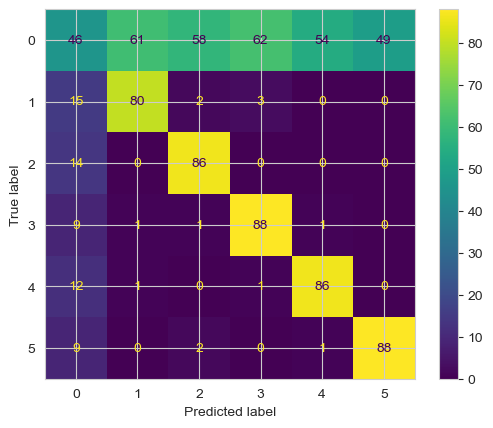

In [287]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [288]:
model2 = SVC(kernel = 'linear', C = 1.0, class_weight = class_weights)
model2.fit(x_train, y_train)
model2.score(x_train, y_train)

0.6060240963855422

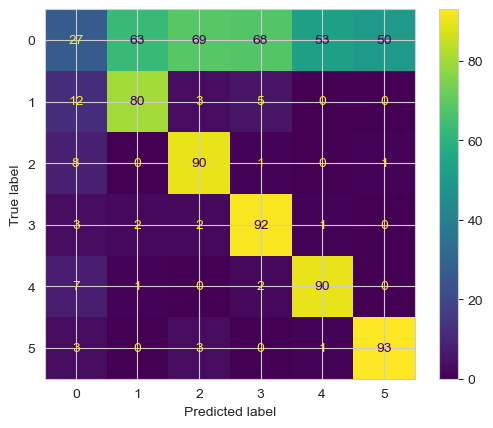

In [289]:
predicted = model2.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

It seems to be difficult for the classifier to differentiate between individual finger movements and no movement periods.

### Movement / no movement classifier

In [290]:
# Scale the data
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)
y = LabelEncoder().fit_transform(key['Event'])

# Update the y label to contain only movement / no movement
y[y != 0] = 1

# Prepare splits
splits = create_splits(x, y)

# Calculate class weights
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes = classes, y = y)
class_weights = dict(zip(classes, class_weights))
class_weights

{0: 1.2575757575757576, 1: 0.83}

In [300]:
#
# Grid search of the best parameters. Runs in parallel using 6 cores. May take a while.
#

param_grid = {
    'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
    'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]
}

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    class_weight = class_weights,
    n_jobs = 6
)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy', verbose = 3)
grid_search.fit(x, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END .......max_depth=2, n_estimators=2;, score=0.523 total time=   0.2s
[CV 2/5] END .......max_depth=2, n_estimators=2;, score=0.569 total time=   0.1s
[CV 3/5] END .......max_depth=2, n_estimators=2;, score=0.499 total time=   0.1s
[CV 4/5] END .......max_depth=2, n_estimators=2;, score=0.588 total time=   0.1s
[CV 5/5] END .......max_depth=2, n_estimators=2;, score=0.525 total time=   0.1s
[CV 1/5] END .......max_depth=2, n_estimators=4;, score=0.520 total time=   0.1s
[CV 2/5] END .......max_depth=2, n_estimators=4;, score=0.549 total time=   0.1s
[CV 3/5] END .......max_depth=2, n_estimators=4;, score=0.477 total time=   0.1s
[CV 4/5] END .......max_depth=2, n_estimators=4;, score=0.480 total time=   0.1s
[CV 5/5] END .......max_depth=2, n_estimators=4;, score=0.561 total time=   0.1s
[CV 1/5] END .......max_depth=2, n_estimators=8;, score=0.530 total time=   0.1s
[CV 2/5] END .......max_depth=2, n_estimators=8

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1.2575757575757576,
                                                            1: 0.83},
                                              criterion='log_loss', n_jobs=6,
                                              random_state=154),
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]},
             scoring='accuracy', verbose=3)

In [301]:
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'max_depth': 32, 'n_estimators': 64}
Best score:  0.5508433734939759


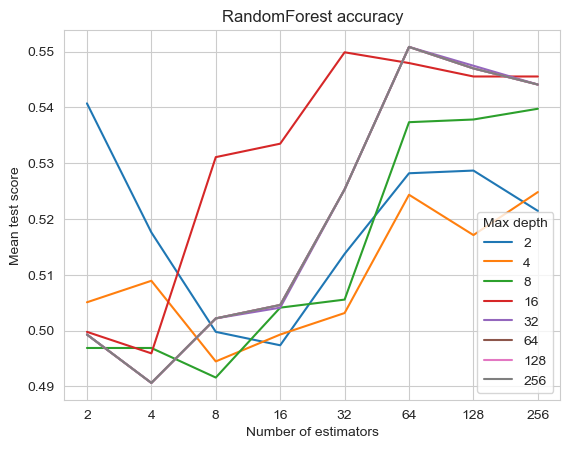

In [340]:
results = pd.DataFrame(grid_search.cv_results_)

for max_depth in np.sort(np.unique(results['param_max_depth'])):
    res = results[results['param_max_depth'] == max_depth]
    plt.plot(np.log(res['param_n_estimators'].astype(float)), res['mean_test_score'], label = max_depth)

plt.legend(title = 'Max depth')
plt.xticks(np.log([2, 4, 8, 16, 32, 64, 128, 256]), np.array([2, 4, 8, 16, 32, 64, 128, 256]))
plt.title('RandomForest accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Mean test score')
plt.show()

In [341]:
max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']

In [343]:
random_forest = []
for split in splits:
    print('Starting another split')
    x_train, y_train, x_test, y_test = split

    model = RandomForestClassifier(
        random_state = 154,
        criterion = 'log_loss',
        n_estimators = n_estimators,
        max_depth = max_depth,
        class_weight = class_weights,
        n_jobs = 6
    )

    model.fit(x_train, y_train)
    random_forest.append(model)

Starting another split
Starting another split
Starting another split
Starting another split
Starting another split


In [402]:
def calculate_model_metrics(models, model_splits):
    model_results = []

    for model_i, split_i in zip(models, model_splits):
        train_x, train_y, test_x, test_y = split_i

        predicted_y = model_i.predict(test_x)

        model_results.append({
            'Accuracy': model_i.score(test_x, test_y),
            'TrainAccuracy': model_i.score(train_x, train_y),
            'MeanPrecisionPerClass': np.mean(precision_score(test_y, predicted_y, average = None)),
            'MeanRecallPerClass': np.mean(recall_score(test_y, predicted_y, average = None))
        })

    return pd.DataFrame(model_results)

In [358]:
random_forest_eval = calculate_model_metrics(models = random_forest, model_splits = splits)

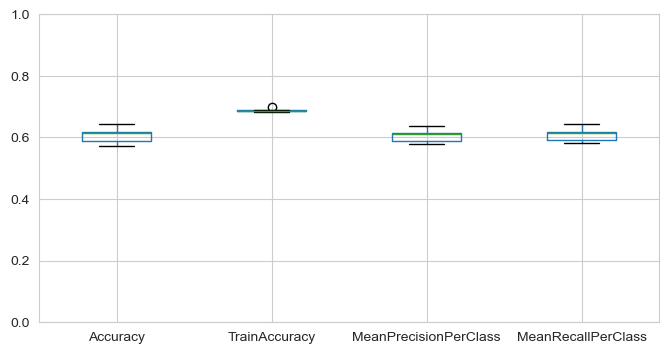

In [365]:
plt.figure(figsize = (8, 4))
random_forest_eval.boxplot()
plt.ylim(0, 1)
plt.show()

In [368]:
best_model_idx = np.argmax(random_forest_eval['Accuracy'])
model = random_forest[best_model_idx]
split = splits[best_model_idx]
x_train, y_train, x_test, y_test = split

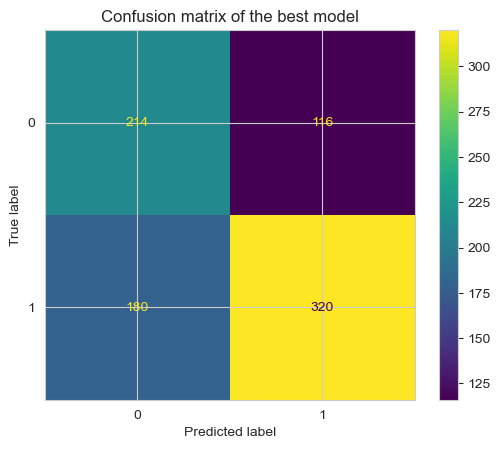

In [370]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix of the best model')
plt.show()

Seems like even with no finger information it is difficult to determine whether there is any movement or not. Wonder why.

### Finger classifier

In [376]:
# Scale the data
x = np.log(feature_matrix.values.T)
x = (x - np.mean(x, axis = 0)) / np.std(x, axis = 0)
y = LabelEncoder().fit_transform(key['Event'])

# Select only finger movement data
x = x[y != 0, :]
y = y[y != 0]

# Prepare splits
splits = create_splits(x, y)

# Calculate class weights
classes = np.unique(y)
class_weights = class_weight.compute_class_weight('balanced', classes = classes, y = y)
class_weights = dict(zip(classes, class_weights))
class_weights

{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}

In [382]:
#
# Grid search of the best parameters. Runs in parallel. May take a while.
#

param_grid = {
    'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
    'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]
}

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    class_weight = class_weights,
    n_jobs = 4
)
grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1_macro', verbose = 3, n_jobs = 2)
grid_search.fit(x, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={1: 1.0, 2: 1.0,
                                                            3: 1.0, 4: 1.0,
                                                            5: 1.0},
                                              criterion='log_loss', n_jobs=4,
                                              random_state=154),
             n_jobs=2,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, 128, 256],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]},
             scoring='f1_macro', verbose=3)

In [386]:
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']

Best set of hyperparameters:  {'max_depth': 32, 'n_estimators': 4}
Best score:  0.23103092199283942


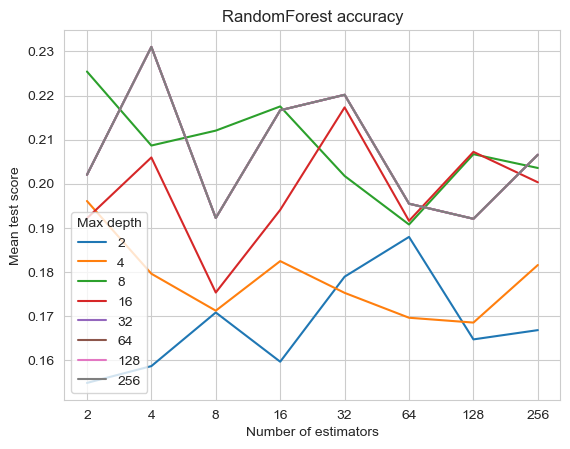

In [384]:
results = pd.DataFrame(grid_search.cv_results_)

for max_depth in np.sort(np.unique(results['param_max_depth'])):
    res = results[results['param_max_depth'] == max_depth]
    plt.plot(np.log(res['param_n_estimators'].astype(float)), res['mean_test_score'], label = max_depth)

plt.legend(title = 'Max depth')
plt.xticks(np.log([2, 4, 8, 16, 32, 64, 128, 256]), np.array([2, 4, 8, 16, 32, 64, 128, 256]))
plt.title('RandomForest accuracy')
plt.xlabel('Number of estimators')
plt.ylabel('Mean test score')
plt.show()

In [385]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.114533,0.043889,0.023224,0.012658,2,2,"{'max_depth': 2, 'n_estimators': 2}",0.211231,0.165313,0.173600,0.103993,0.119868,0.154801,0.038601,64
1,0.158487,0.130651,0.029815,0.018568,2,4,"{'max_depth': 2, 'n_estimators': 4}",0.243680,0.204934,0.147429,0.118095,0.078940,0.158616,0.059155,63
2,0.069181,0.005422,0.016695,0.000620,2,8,"{'max_depth': 2, 'n_estimators': 8}",0.217980,0.202734,0.148713,0.128896,0.155581,0.170781,0.033826,57
3,0.082158,0.004635,0.016926,0.000481,2,16,"{'max_depth': 2, 'n_estimators': 16}",0.259195,0.209872,0.062693,0.111244,0.155059,0.159613,0.069565,62
4,0.169625,0.009605,0.017927,0.001384,2,32,"{'max_depth': 2, 'n_estimators': 32}",0.238243,0.243243,0.091622,0.105292,0.216116,0.178903,0.066456,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.257327,0.028399,0.017112,0.000622,256,16,"{'max_depth': 256, 'n_estimators': 16}",0.311405,0.189944,0.194149,0.172071,0.215732,0.216660,0.049368,12
60,0.500390,0.020415,0.017794,0.000775,256,32,"{'max_depth': 256, 'n_estimators': 32}",0.269830,0.208803,0.213736,0.230752,0.177727,0.220170,0.030167,6
61,1.068809,0.065672,0.019269,0.005725,256,64,"{'max_depth': 256, 'n_estimators': 64}",0.244320,0.182674,0.186537,0.202611,0.161179,0.195464,0.027773,33
62,1.939156,0.065164,0.028602,0.001053,256,128,"{'max_depth': 256, 'n_estimators': 128}",0.228381,0.219766,0.121361,0.234485,0.156188,0.192036,0.045104,43


In [387]:
split = splits[0]
x_train, y_train, x_test, y_test = split

model = RandomForestClassifier(
    random_state = 154,
    criterion = 'log_loss',
    n_estimators = n_estimators,
    max_depth = max_depth,
    class_weight = class_weights
)

model.fit(x_train, y_train)
model.score(x_train, y_train)

0.9615

In [400]:
random_forest_fingers = []
for split in splits:
    print('Starting another split')
    x_train, y_train, x_test, y_test = split

    model = RandomForestClassifier(
        random_state = 154,
        criterion = 'log_loss',
        n_estimators = n_estimators,
        max_depth = max_depth,
        class_weight = class_weights,
        n_jobs = 6
    )

    model.fit(x_train, y_train)
    random_forest_fingers.append(model)

Starting another split
Starting another split
Starting another split
Starting another split
Starting another split


In [403]:
random_forest_eval = calculate_model_metrics(models = random_forest_fingers, model_splits = splits)

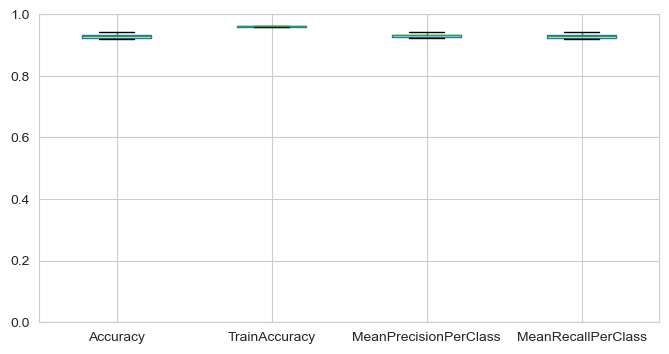

In [404]:
plt.figure(figsize = (8, 4))
random_forest_eval.boxplot()
plt.ylim(0, 1)
plt.show()

In [407]:
best_model_idx = np.argmax(random_forest_eval['Accuracy'])
model = random_forest_fingers[best_model_idx]
split = splits[best_model_idx]
x_train, y_train, x_test, y_test = split

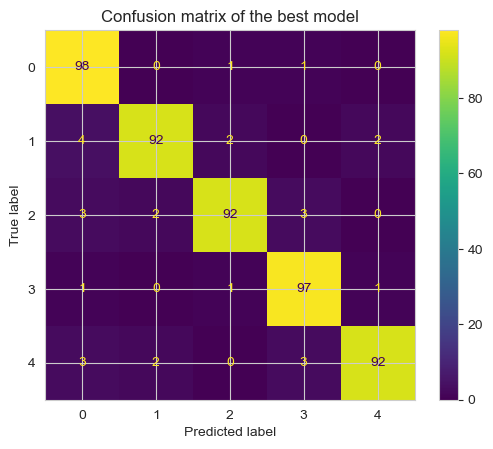

In [408]:
predicted = model.predict(x_test)
cm = confusion_matrix(y_test, predicted, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title('Confusion matrix of the best model')
plt.show()

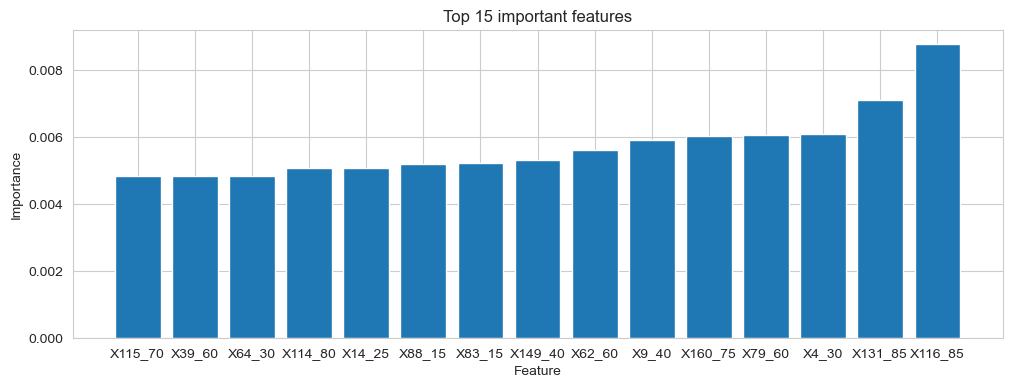

In [445]:
plt.figure(figsize = (12, 4))
importance = model.feature_importances_
forest_importance = pd.Series(importance, index = feature_matrix.index)
forest_importance = forest_importance.sort_values()

plt.bar(x = forest_importance[-15:].index, height = forest_importance[-15:])
plt.title('Top 15 important features')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

In [472]:
# Perform PCA using important features only
pca = PCA(n_components = 3).fit_transform(x[:, forest_importance > 0.002])

fig = go.Figure(data=[go.Scatter3d(
    x = pca[:, 0],
    y = pca[:, 1],
    z = pca[:, 2],
    mode='markers',
    marker=dict(color=y, size = 3)
)])

fig.update_layout(width=800, height=600)
fig.update_layout(scene = dict(xaxis_title = 'PCA 1', yaxis_title = 'PCA 2', zaxis_title = 'PCA 3'))
fig.update_layout(title = 'PCA of important features')
fig.show()